In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil

# Source: Google Drive folder
src_path = "/content/drive/MyDrive/Research/Dataset/Dataset/Potato"

# Destination: Colab local directory
dest_path = "/content/dataset/Potato"

# Copy the folder
shutil.copytree(src_path, dest_path)

print("✅ Folder copied successfully!")

✅ Folder copied successfully!


In [3]:
import os

dataset_path = dest_path

if not os.path.exists(dataset_path):
    print(f"❌ Dataset path not found: {dataset_path}")
else:
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    print(f"\n✅ Number of classes: {len(class_counts)}")
    print("📊 Images per class:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")



✅ Number of classes: 9
📊 Images per class:
  Potato___phytophthora: 347 images
  Potato___leafroll_virus: 527 images
  Potato___pests: 611 images
  Potato___bacterial_wilt: 569 images
  Potato___nematode: 68 images
  Potato___healthy: 2275 images
  Potato___late_blight: 2087 images
  Potato___mosaic_virus: 666 images
  Potato___early_blight: 2628 images


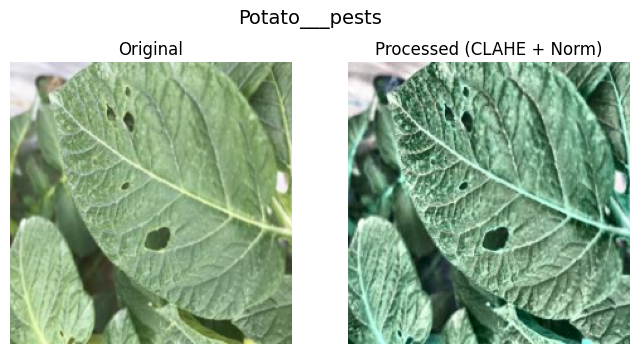

In [17]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# ✅ ইনপুট এবং আউটপুট ফোল্ডার
input_folder = dest_path         # মূল ছবির ফোল্ডার
output_folder = 'potato_dataset_processed'  # প্রসেসড ছবির গন্তব্য ফোল্ডার

# ✅ টার্গেট সাইজ
target_size = (224, 224)

# ✅ CLAHE সেটআপ
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# ✅ Image preprocessing ফাংশন
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    img_resized = cv2.resize(img, target_size)

    # CLAHE প্রয়োগ
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Normalization
    img_normalized = img_clahe.astype('float32') / 255.0

    return img_resized, img_normalized

# ✅ Image Preview ফাংশন
def show_images(original, processed, title=''):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(processed)
    plt.title('Processed (CLAHE + Norm)')
    plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# ✅ এক ক্লাস থেকে শুধু ১টা ছবির প্রিভিউ দেখানো (পরীক্ষামূলকভাবে)
sample_class = 'Potato___pests'  # ক্লাসের নাম (ফোল্ডারের নাম)
sample_img = os.listdir(os.path.join(input_folder, sample_class))[11]
img_path = os.path.join(input_folder, sample_class, sample_img)

original_img, processed_img = preprocess_image(img_path)
show_images(original_img, processed_img, title=sample_class)


In [18]:
# ✅ ব্যাচ প্রিপ্রসেসিং + সেভ শুরু
for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    save_class_path = os.path.join(output_folder, class_name)
    os.makedirs(save_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_class_path, img_name)

        original_img, processed_img = preprocess_image(img_path)
        if processed_img is not None:
            # [0,1] → [0,255] → uint8 → BGR
            processed_img_uint8 = (processed_img * 255).astype('uint8')
            cv2.imwrite(save_path, processed_img_uint8)


In [19]:
# ✅ Potato classes-wise HSV color range (adjust/tune as needed)
classwise_hsv_ranges = {
    'Potato___healthy':              ([35, 40, 40], [90, 255, 255]),   # healthy green leaf
    'Potato___phytophthora':         ([20, 30, 30], [80, 255, 255]),   # brownish-black patch
    'Potato___leafroll_virus':       ([25, 40, 50], [75, 255, 255]),   # yellowing with minor purple tint
    'Potato___pests':                ([15, 30, 20], [70, 255, 255]),   # pest marks often brown/black
    'Potato___bacterial_wilt':       ([30, 50, 50], [85, 255, 255]),   # wilted and sometimes yellowish
    'Potato___nematode':             ([25, 30, 40], [75, 255, 255]),   # dark green or rough spots
    'Potato___late_blight':          ([10, 30, 30], [65, 255, 255]),   # dark brown/black lesion
    'Potato___mosaic_virus':         ([30, 30, 60], [85, 255, 255]),   # light green and yellow patchy
    'Potato___early_blight':         ([15, 30, 30], [80, 255, 255])    # brown circular spots
}


In [20]:
def smart_leaf_crop(img_path, class_name, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # ✅ ক্লাস অনুযায়ী HSV রেঞ্জ ব্যবহার করো
    lower_val, upper_val = classwise_hsv_ranges.get(class_name, ([25,40,40], [95,255,255]))
    lower_green = np.array(lower_val)
    upper_green = np.array(upper_val)

    mask = cv2.inRange(hsv, lower_green, upper_green)

    # ✅ কনট্যুর খুঁজে বড় পাতাটি বের করা
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img, None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]

    # ✅ রিসাইজ
    resized = cv2.resize(cropped, target_size)

    # ✅ CLAHE + Normalize
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    processed = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    normalized = processed.astype('float32') / 255.0

    return img, normalized


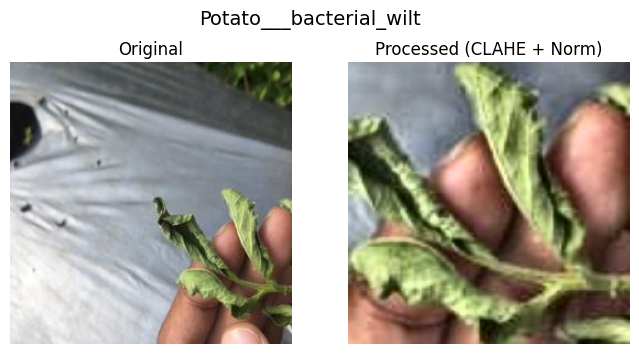

In [21]:
class_name = 'Potato___bacterial_wilt'
test_image_path = f'/content/dataset/Potato/Potato___bacterial_wilt/108394.jpg'
original_img, processed_img = smart_leaf_crop(test_image_path, class_name)
if processed_img is not None:
    show_images(original_img, processed_img, title=class_name)
else:
    print("Leaf not detected in the image.")


In [22]:
import os
from tqdm import tqdm

# ✅ ইনপুট ও আউটপুট ফোল্ডার
input_root = '/content/dataset/Potato'
output_root = '/content/Potato'  # এখানে সেভ হবে

# ✅ সব ক্লাসের উপর লুপ চালাও
for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    # ✅ সেভ ফোল্ডার বানাও
    save_folder = os.path.join(output_root, class_name)
    os.makedirs(save_folder, exist_ok=True)

    # ✅ প্রতিটি ছবির উপর কাজ করো
    for img_name in tqdm(os.listdir(class_path), desc=f'Processing {class_name}'):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_folder, img_name)

        try:
            original_img, processed_img = smart_leaf_crop(img_path, class_name)
            if processed_img is not None:
                # [0–1] scale → [0–255] uint8 এ রূপান্তর
                img_uint8 = (processed_img * 255).astype('uint8')
                img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
                cv2.imwrite(save_path, img_bgr)
        except Exception as e:
            print(f"Failed on {img_path}: {e}")


Processing Potato___early_blight: 100%|██████████| 2628/2628 [00:18<00:00, 139.97it/s]


In [23]:
import shutil

input_folder = '/content/Potato'  # তোমার প্রসেসড ছবির মূল ফোল্ডার
zip_path = '/content/Potato_Preprocessed.zip'

shutil.make_archive(zip_path.replace('.zip', ''), 'zip', input_folder)
print("✅ Zipping done!")


✅ Zipping done!


In [24]:
# ✅ গন্তব্য ডিরেক্টরি (Drive-এ যেখানে রাখতে চাও)
drive_folder = '/content/drive/MyDrive/Research/Dataset/Preproceessed/Potato'

# গন্তব্য ফোল্ডার যদি না থাকে, তৈরি করো
os.makedirs(drive_folder, exist_ok=True)

# ✅ কপি করো
shutil.copy(zip_path, os.path.join(drive_folder, 'Potato_Preprocessed.zip'))
print(f"✅ Uploaded to Google Drive: {drive_folder}")


✅ Uploaded to Google Drive: /content/drive/MyDrive/Research/Dataset/Preproceessed/Potato
